In [34]:
import torch
import clip
import numpy as np
from PIL import Image
import os
import matplotlib.pyplot as plt
import skimage
import cv2

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

100%|████████████████████████████████████████| 338M/338M [08:00<00:00, 736kiB/s]


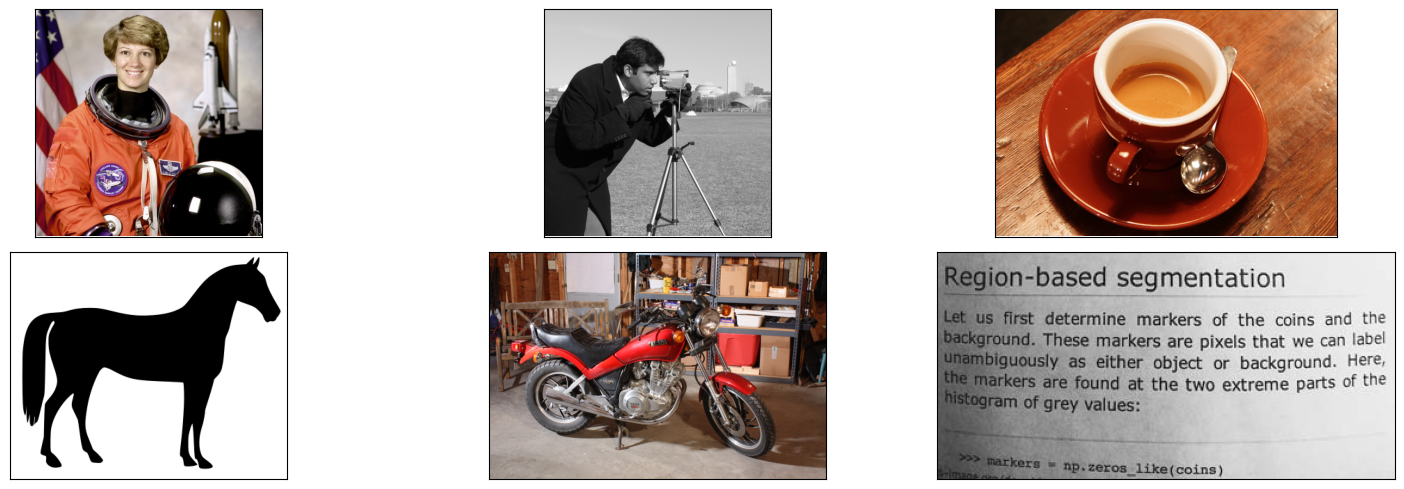

In [33]:
target_classes = ["page", "astronaut", "motorcycle_right", "camera", "horse", "coffee"]

original_images = []
image_embeddings = []
plt.figure(figsize=(16, 5))

for filename in [filename for filename in os.listdir(skimage.data_dir) if filename.endswith(".png")]:
    name = os.path.splitext(filename)[0]
    if name not in target_classes:
        continue
    image = Image.open(os.path.join(skimage.data_dir, filename)).convert("RGB")
    
    plt.subplot(2, 3, len(image_embeddings) + 1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    
    original_images.append(image)
    image_embeddings.append(preprocess(image))
    
plt.tight_layout()

In [20]:
with torch.no_grad():
    image_input = torch.tensor(np.stack(image_embeddings)).to(device)
    image_features = model.encode_image(image_input).float()
    image_features /= image_features.norm(dim=-1, keepdim=True)

In [21]:
with torch.no_grad():
    text_descriptions = [f"This is a photo of a {label}" for label in target_classes]
    text_tokens = clip.tokenize(text_descriptions).to(device)
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

In [22]:
text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels  = text_probs.cpu().topk(5, dim=-1)

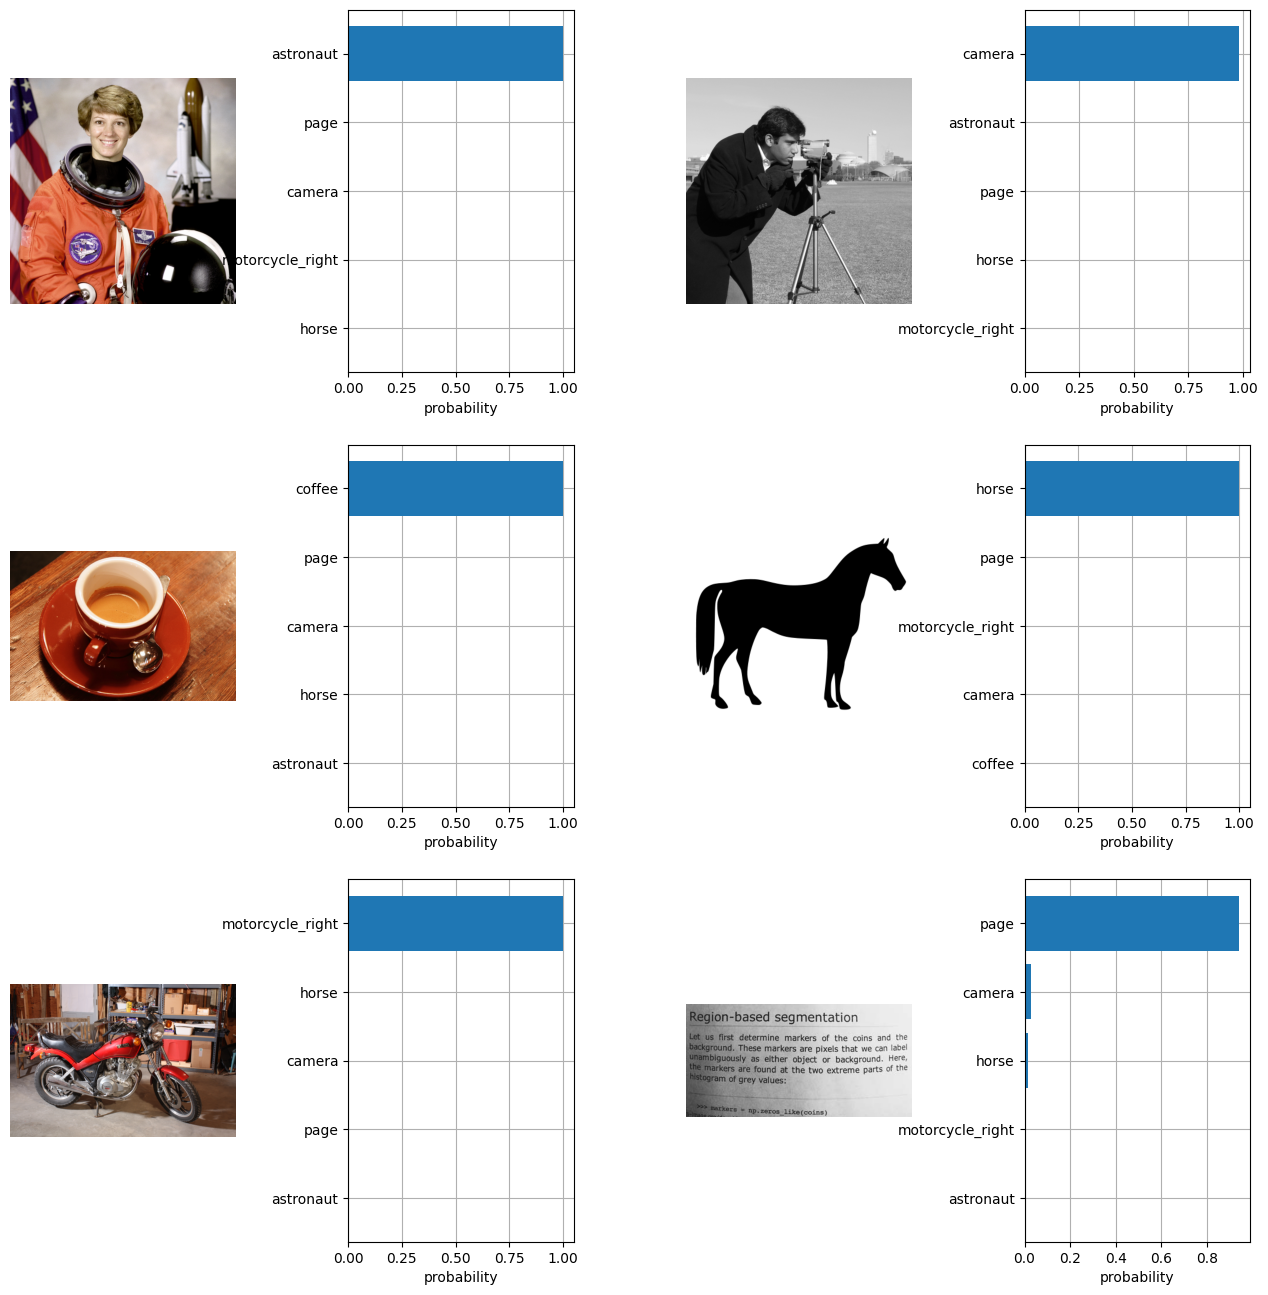

In [25]:
plt.figure(figsize=(16,16))

for i, image in enumerate(original_images):
    plt.subplot(3, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")
    
    plt.subplot(3, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [target_classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")
    
plt.subplots_adjust(wspace=0.5)
plt.show()